# Part 0: Initialising

In [1]:
# Initializing
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)

import warnings

warnings.filterwarnings("ignore")


To start with, we import three datasets that are available on YouNiverse:

``df_timeseries_en.tsv.gz``  
``df_channels_en.tsv.gz``  
``yt_metadata_helper.feather``

In [2]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])


In [3]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)


In [4]:
df_time_series.head(2)


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.0,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.0,395.777778,6,1,1


In [5]:
df_channels.head(2)


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


In [6]:
video_metadatas.head(2)


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA


# Part 1: Initial Analysis and Data Visualization

In this section, we analyze the YouNiverse data to determine the potential factors that could lead to success on Youtube. This initial analysis will help us narrow down a subset of the dataset to focus on for our Milestone 3 analysis.

## Question 1: How is the weekly content creation pattern of Youtubers regarding the upload frequency, video lengths, upload time?

### Section 1: Video Upload Frequency

In this section, we mainly consider the weekly video upload frequency. To do that, we first group the `video_metadatas` by upload week for all channels, to have an idea on the upload trends. We do not use `df_time_series` for the purpose of this section, which has ready-to-use weekly information regarding each channel, as it only considers the data from 2015-01-05 to 2019-10-06.

In [7]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)


In [8]:
for year in range(2005, 2021):
    total_videos_year = video_count[video_count.index.year.isin([year])].sum()
    print("We have {:_} video in {}".format(total_videos_year, year))


We have 316 video in 2005
We have 23_310 video in 2006
We have 136_829 video in 2007
We have 334_681 video in 2008
We have 690_303 video in 2009
We have 1_078_624 video in 2010
We have 1_860_819 video in 2011
We have 2_948_031 video in 2012
We have 4_004_505 video in 2013
We have 5_158_285 video in 2014
We have 6_773_572 video in 2015
We have 9_276_405 video in 2016
We have 12_640_131 video in 2017
We have 15_236_607 video in 2018
We have 12_762_376 video in 2019
We have 0 video in 2020


Text(0.5, 1.0, 'Number of videos uploaded each week')

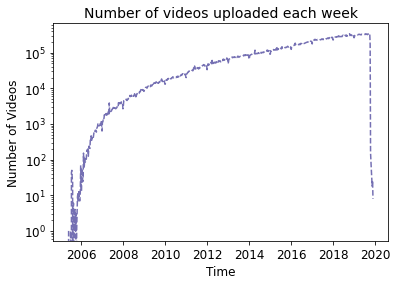

In [9]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos uploaded each week")


From the graph above, we can see that the number of videos being uploaded to YouTube has increased steadily since 2005. We want to have a closer look at the number of videos uploaded by each channel to understand how many videos it takes in order to be successfull. For this preliminary analysis, we only consider the number of videos uploaded by each channel per year.

In [10]:
# The following graph shows how many videos each channel uploads to YouTube per year.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_yr.columns.name = None
vd_cnt_by_id_yr_summary = vd_cnt_by_id_yr.describe()


Text(0.5, 1.0, 'The 2nd and 3rd quartiles of yearly video upload frequency')

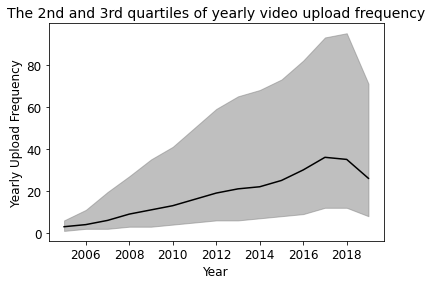

In [11]:
plt.fill_between(
    x=list(vd_cnt_by_id_yr_summary.columns.values),
    y1=list(vd_cnt_by_id_yr_summary.loc["25%", :]),
    y2=list(vd_cnt_by_id_yr_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_cnt_by_id_yr_summary.loc["50%", :], color="black")
plt.xlabel("Year")
plt.ylabel("Yearly Upload Frequency")
plt.title("The 2nd and 3rd quartiles of yearly video upload frequency")
# here we choose quartiles, since the mean would be significantly affected by extremely high yearly upload rates


This graphs shows that YouTubers upload more videos every year with time, and the variation of upload frequency between channels also increased significantly since the beginning of the study period.

### Section 2: Video Lengths

Firstly, we will take a look at the basic statistics of video lengths using `video_metadatas` . To make it easier to understand, we first convert the duration into minutes for the subsequent analysis.

In [12]:
# divide the video duration by 60 to convert duration to minutes
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()


count    7.292479e+07
mean     1.262794e+01
std      3.033518e+01
min      1.666667e-02
25%      2.233333e+00
50%      4.733333e+00
75%      1.163333e+01
max      6.002617e+03
Name: duration_min, dtype: float64

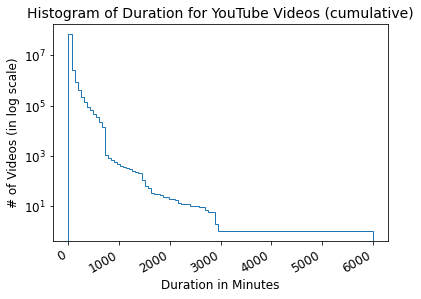

In [13]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()


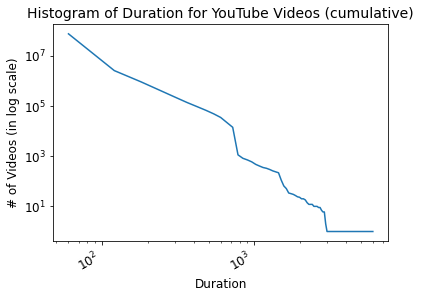

In [14]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()


From the basic statistical information and the histogram, we can observe a significant difference between the mean (12.63 minutes) and the median (4.73 minutes). Furthermore, the maximum duration (100 hours) is much higher compared to both, the median and the mean. The distribution of the duration resembles that of a heavy tail distribution. This observation suggests that there are extremely long videos in the dataset that would increase the mean significantly. Therefore, a visualization with quartiles serves as a less distorted representation of the dataset as it does not consider outliers.

Therefore, we will have a look at the quartiles of duration of videos in the dataset to have a better idea about the distribution: 

Text(0.5, 1.0, 'Duration of Videos in Minutes')

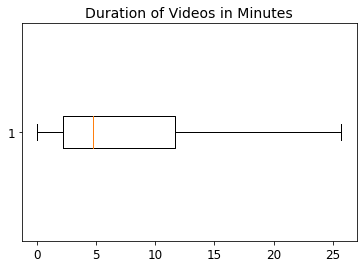

In [15]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")


Here, we see that throughout the study period, most of the videos are between zero and 25 minutes long. To investigate whether the variation of video length is also varying with time, we take a look at the evolution of this information.

In [16]:
vd_duration_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])["duration_min"]
    .mean()
    .unstack()
    .reset_index()
)
vd_duration_by_id_yr.columns.name = None
vd_duration_by_id_yr_summary = vd_duration_by_id_yr.describe()


Text(0.5, 1.0, 'The 2nd and 3rd quartiles of average yearly video duration')

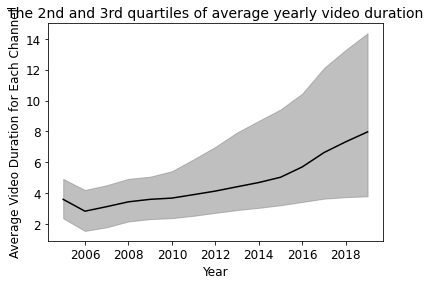

In [17]:
plt.fill_between(
    x=list(vd_duration_by_id_yr_summary.columns.values),
    y1=list(vd_duration_by_id_yr_summary.loc["25%", :]),
    y2=list(vd_duration_by_id_yr_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_duration_by_id_yr_summary.loc["50%", :], color="black")
plt.xlabel("Year")
plt.ylabel("Average Video Duration for Each Channel")
plt.title("The 2nd and 3rd quartiles of average yearly video duration")
# here we choose quartiles, since the mean would be significantly affected by extremely high yearly upload rates


From this graph, it is obvious that the variance of mean video duration for each channel is increasing with time, and the median itself is also increasing with time. This means that comparing to the beginning of study period, channels increased the video duration, and there are more channels with vastly different video duration towards the end of the study period.

### Section 3: Upload Time
In this section, we want to investigate at what points during the week YouTubers upload their videos.

In [18]:
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday
vd_cnt_by_id_wk = (
    video_metadatas.groupby(["channel_id", "weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_wk.columns.name = None
vd_cnt_by_id_wk["mean_upload"] = vd_cnt_by_id_wk.iloc[:, 2:].mean(axis=1, skipna=True)


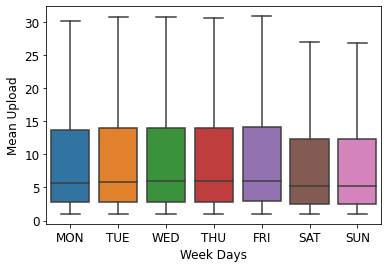

In [19]:
labels = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
ax = sns.boxplot(
    x="weekNumber", y="mean_upload", data=vd_cnt_by_id_wk, showfliers=False
).set(xlabel="Week Days", ylabel="Mean Upload", xticklabels=labels)


This boxplot shows that the variation between upload rate during weekdays are not significantly different. However, during the weekend, it seems that mean upload rate is less than during the week. In the next step, we visualize it better by counting the total number of videos uploaded each day of the week, regardless of the channel ID:

In [20]:
vd_cnt_by_wk = (
    video_metadatas.groupby(["weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_wk.columns.name = None


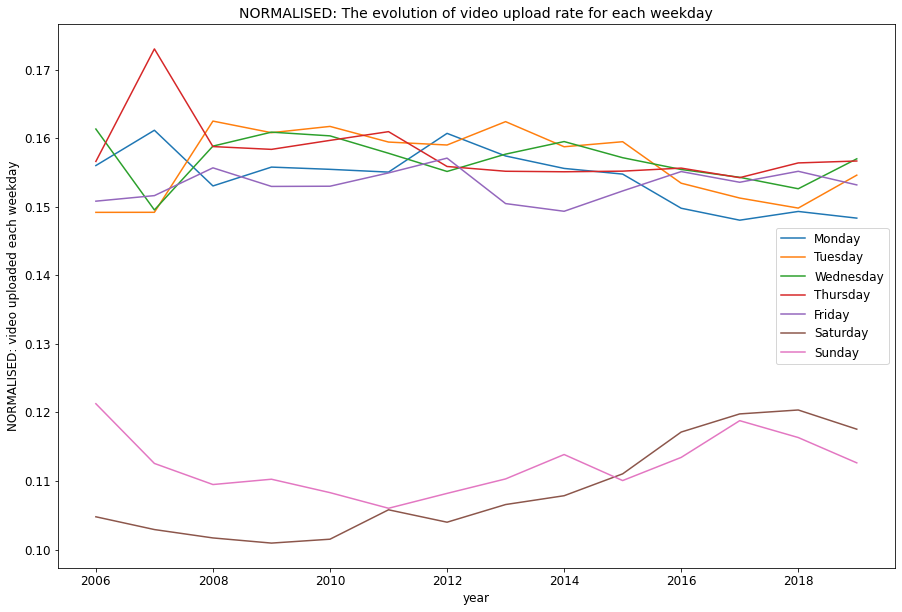

In [21]:
vd_cnt_by_wk_norm = vd_cnt_by_wk.iloc[:, 2:] / vd_cnt_by_wk.iloc[:, 2:].sum(skipna=True)
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot(vd_cnt_by_wk_norm.T)
plt.legend(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.xlabel("year")
plt.ylabel("NORMALISED: video uploaded each weekday")
plt.title("NORMALISED: The evolution of video upload rate for each weekday")
plt.show()


This graph suggests that the number of videos uploaded from Monday to Friday is not significantly different from each other throughout the study period. Generally speaking, YouTubers upload more during weekdays than during the weekends. However, we can also observe an increasing number of videos uploaded on Saturdays in more recent years.

## Question 2: How are the subscription patterns for reaching key numbers of subscribers, aka, 1k, 10k, 100k, 1M?

In this section, we investigate the time frame for YouTubers to reach key milestones in their channel success - number of subscriptions.

In [22]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end


In [23]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs


In [24]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with at most 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)


We have 1252 channels that begins with at most 10K subs and reach at least 1M


Example to deal with the function defined above

There are 113 weeks for this channel
We should have approximately the same value : 
791 and 784 days 00:00:00


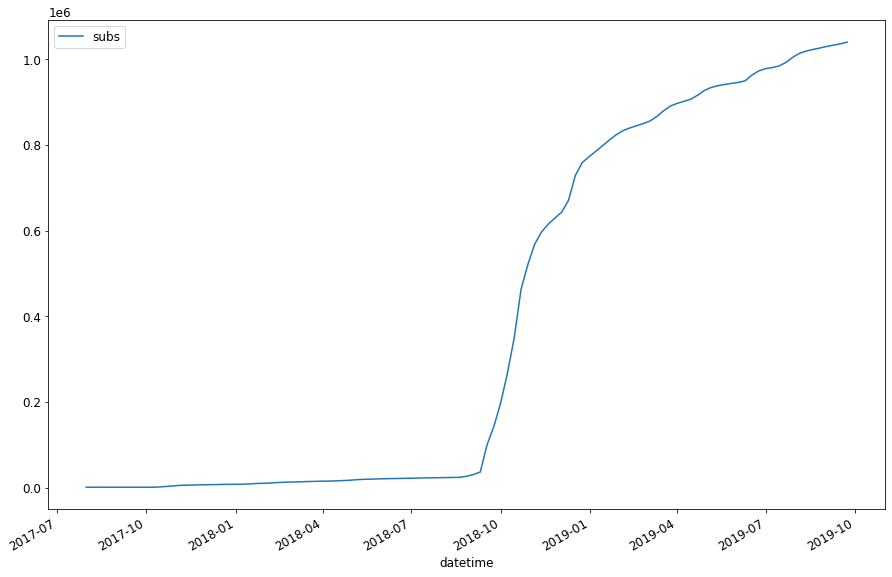

In [25]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))

# just check that the first dimension of the test df (it gives the nb of weeks) multiplied
# by 7 (it gives the total nb of days) is equal to the last date - first date. If yes, then we have a continuous
# chronology
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)


In [26]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()


,from_zero_to_hero_duration
channel,
UC-3fLOkTRb7-tepOqxsDdDg,97 days 23:00:00
UC-5Yj4HIiruwkzFuLflxL_w,574 days 01:00:00
UC-CSyyi47VX1lD9zyeABW3w,769 days 23:00:00
UC-HOjVdbw0TG6h44rH4Sirw,413 days 00:00:00
UC-LUjxkSJCxAMrZ4S0T3Drg,686 days 01:00:00


In [27]:
print(
    "In average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)


In average YTbers take 511 days to reach 1M of subscribers


We will then bootstrap this result for Milestone 3 to see the time it takes to reach 1M subscribers and its confidence interval.

In [28]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)


In [29]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M

print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)


The 95% interval of confidence, the time taken to reach 1M (from 10K) is [498.3132106067498, 523.487187729794]


## Question 3: Which categories are more popular during the study period? Which types of videos receive more positive feedback?

In this question, we will use `video_metadatas` to determine which categories are more popular and have a high amount of views. This step helps in narrowing down our categories of interest to three categories that we want to investigate further for Milestone 3.

### Section 1: Number of Views

In [30]:
#  make a copy of the video_metadatas
videos_with_cat = video_metadatas[:]
videos_with_cat["categories"] = videos_with_cat["categories"].apply(
    lambda x: x.replace(" & ", "_")
)

# delete the rows with empty categories
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)


In [31]:
encoded_cat = pd.get_dummies(videos_with_cat.categories)
video_metadatas_encoded = videos_with_cat.join(encoded_cat)
video_metadatas_encoded["year"] = video_metadatas_encoded["upload_date"].dt.year


In [70]:
# Average view counts for videos from each category across time
mean_views = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).mean()
)
mean_views = mean_views.view_count.unstack().reset_index()
mean_views.columns.name = None
mean_views = mean_views.sort_values(
    by=2019, ascending=False, ignore_index=True
)

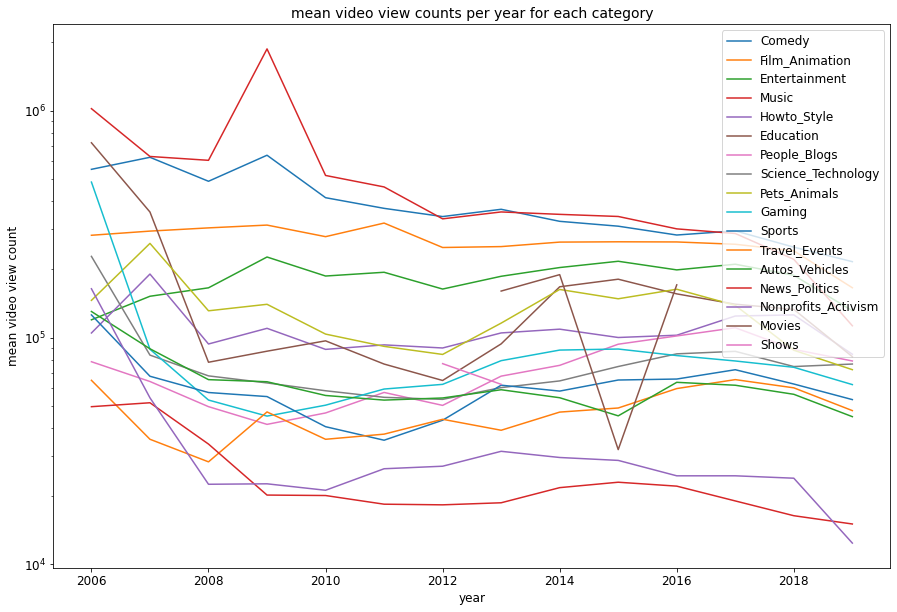

In [73]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(mean_views.shape[0]):
    plt.plot(
        mean_views.loc[
            i,
        ][2:],
        label=mean_views.loc[i,][
            0:1
        ][0],
    )
plt.semilogy()    
plt.legend(loc="upper right")
plt.xlabel("year")
plt.ylabel("mean video view count")
plt.title("mean video view counts per year for each category")
plt.show()

The results of the data above is obtained by averaging the view counts of all videos in the same category by year. It shows that on average, Music and Comedy are the two top categories for view counts from 2005 to 2017. From 2018 to 2019, Film & Animation replaces Music on the top two spots. However, all top four categories are showing a decrease in their mean video view counts. However, there is not a genre of videos that shows obvious growth in mean video view counts over the study period, while most of the categories seem to stay more or less the same level, non-profit and news & politics categories seem to have obvious drop in their mean video view counts.

Now let's investigate how popular are the videos from each category, and how the trend changes over time. For this purpose, we will now shift to the total video view counts, instead of the mean ones.

In [34]:
# determine how many videos are uploaded to YouTube by each channel by year
video_count_by_year = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).sum()
)
video_view_count_by_year = video_count_by_year.view_count.unstack().reset_index()
video_view_count_by_year.columns.name = None
video_view_count_by_year = video_view_count_by_year.sort_values(
    by=2019, ascending=False, ignore_index=True
)
# NOTE THAT CATEGORIES::MOVIES AND SHOWS HAVE VERY FEW DATA!


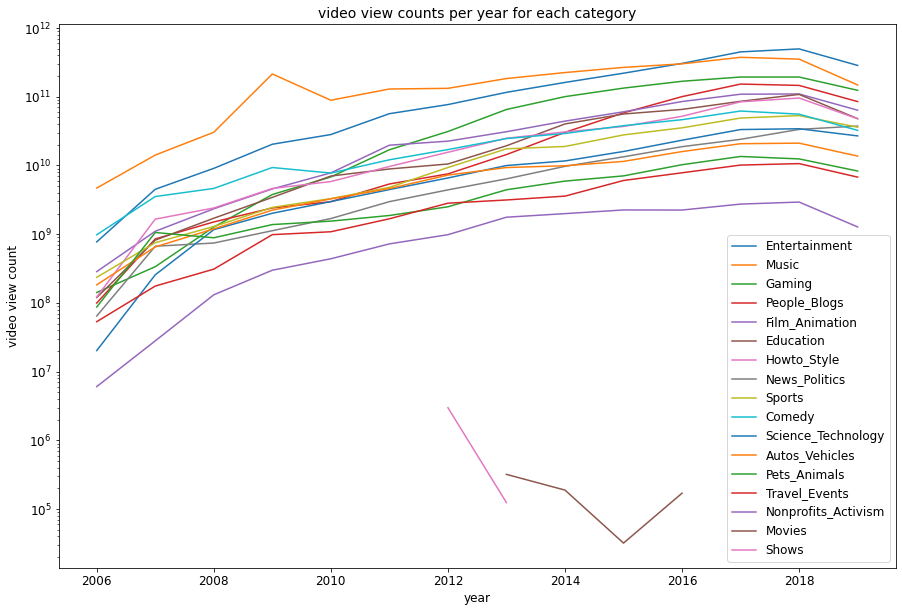

In [78]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.semilogy()    
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("video view count")
plt.title("video view counts per year for each category")
plt.show()


From previous plot, we could see that by 2019, the top four categories with highest mean view counts are Comedy, Film & Animation, Music, Gaming, whereas People & Blogs was placed at the 7th. However, here we can observe that the total view counts for People & Blogs now enters the top four. This means that although that videos under People & Blogs have on average less views per video, there are probably a lot of videos under People & Blogs. Let's verify this observation by another plot.


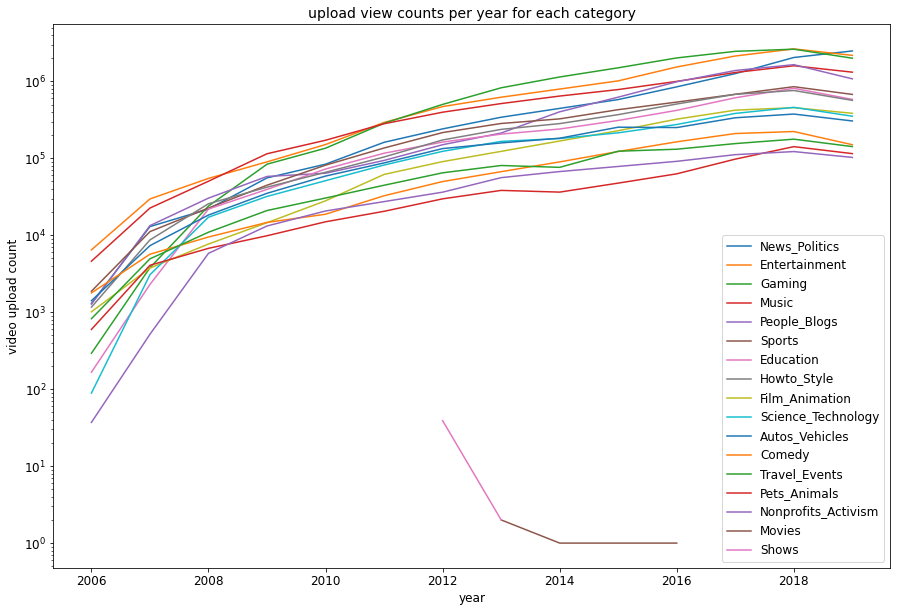

In [86]:
# determine how many videos are uploaded to YouTube by each channel by year
upload_count_by_year = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).count()
)
upload_count_by_year = upload_count_by_year.view_count.unstack().reset_index()
upload_count_by_year.columns.name = None
upload_count_by_year = upload_count_by_year.sort_values(
    by=2019, ascending=False, ignore_index=True
)

plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(upload_count_by_year.shape[0]):
    plt.plot(
        upload_count_by_year.loc[
            i,
        ][2:],
        label=upload_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.semilogy()    
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("video upload count")
plt.title("upload counts per year for each category")
plt.show()

Here we can observe that indeed there are more videos under people & Blogs category, compared to the other two categories with high mean view counts, Comedy and Film & Animation. This result suggests that the high total view counts can beat Comedy and Film & Animation probably because of its high number of videos uploaded.

Lastly, we want to find out how are the video views distributed between different categories for each year. To do that, we will divide the total video counts per category per year by total video counts per year.

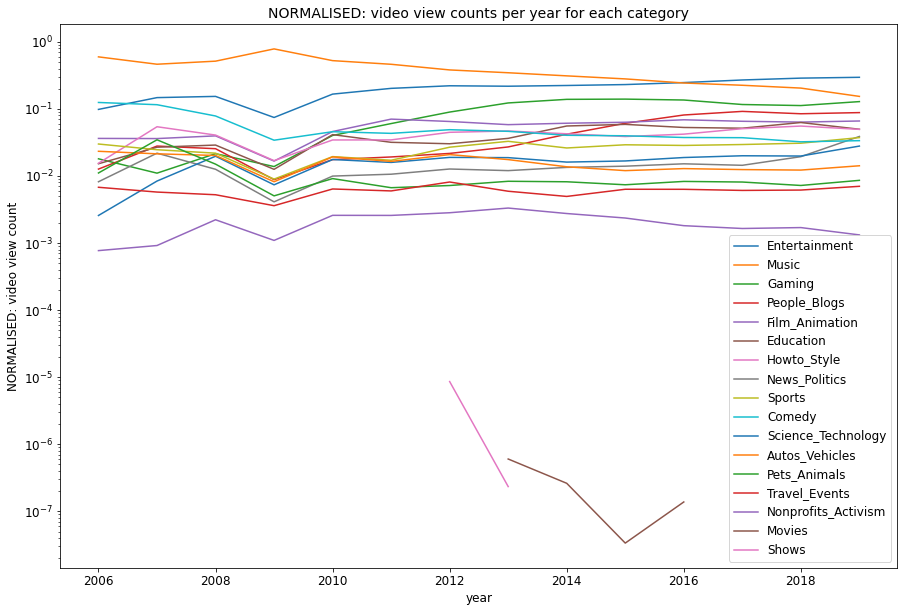

In [88]:
# NORMALISATION:
## 1. view count - normalise wrt. total video views per year, to see which categories is viewed more every year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:]
        / video_view_count_by_year.sum(axis=0)[2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.semilogy()  
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("NORMALISED: video view count")
plt.title("NORMALISED: video view counts per year for each category")
plt.show()
# view on music videos decreases, whereas on entertainment and gaming increases

The result indicates that the share of video counts across different categories are quite stable across the study period. However, it is also obvious that the view counts for Music is decreasing, and that for Entertainment, Gaiming and People & Blogs are somewhat increasing.

TO-DO: ADD NOTES

In [91]:
# use the time series dataframe to implement this, it would be easier. 
df_time_series['year'] = df_time_series.datetime.dt.year
df_time_series.sample(4)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,year
4971089,UCTX9ksYk8VGBcCYEsF-W91g,Pets & Animals,2019-02-03 23:00:00,8.840728e+06,5.115849e+05,57151.0,2958.932292,86,3,5,2019
3497068,UCwDpwTivDhNkIhkECrA7aBA,Howto & Style,2018-10-01 00:00:00,1.514688e+04,1.617875e+03,1893.0,84.875000,3,0,1,2018
2283988,UCsbIsbmVFubTo-HVOu9DYXg,People & Blogs,2018-07-30 01:00:00,3.439635e+06,7.381266e+03,10407.0,12.796875,371,1,1,2018
16116794,UCGjn3ZbkkNcQaj00qwJ0DYQ,Entertainment,2017-07-10 00:00:00,8.297247e+07,1.080909e+06,125011.0,1588.875000,2164,46,88,2017


In [92]:
# penalize the big channel (many subs) by dividing the number of delta views by nb of total subscribers
df_time_series['views_over_subs'] = df_time_series.delta_views / df_time_series.subs
df_time_series.sample(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,year,views_over_subs
6272971,UCNmfuDtKkWJfWe4zh9MBrUA,People & Blogs,2016-10-24 00:00:00,9.976759e+06,2.227899e+05,91827.0,1234.625000,111,2,2,2016,2.426191
10257204,UCUGujz-7Q60LLxdBhpgcnQA,Entertainment,2018-05-28 00:00:00,2.052085e+08,5.231825e+05,463804.0,1815.000000,2970,2,10,2018,1.128025
12480794,UCi0iJvEVojAqg-OBp0X364Q,Music,2018-09-17 00:00:00,2.604268e+08,7.094501e+06,1437686.0,26085.500000,152,3,6,2018,4.934667
9795866,UCvY2q3r-ibLTsF4QGfIdFRQ,Music,2017-02-05 23:00:00,2.422175e+07,2.031840e+05,95953.0,809.276042,190,1,2,2017,2.117536
10087086,UCCiEKK4835FTejF4ogW4P-A,Gaming,2018-05-28 00:00:00,3.394712e+07,4.305658e+05,172004.0,1426.750000,596,5,9,2018,2.503231


In [93]:
df_time_series[df_time_series.delta_views == 0].category.value_counts()

Entertainment            94260
Music                    85789
Gaming                   78886
People & Blogs           57165
Howto & Style            34227
Education                26488
Film and Animation       25814
Sports                   18834
Science & Technology     16352
Comedy                   15967
Autos & Vehicles         11119
News & Politics           9185
Travel & Events           5851
Pets & Animals            3835
Nonprofits & Activism     3567
Name: category, dtype: int64

In [94]:
views_over_subs_per_year = (
    df_time_series.groupby(["category", "year"]).sum()
)
views_over_subs_per_year.head(10)

views   delta_views          subs    delta_subs  \
category         year                                                           
Autos & Vehicles 2015  2.996063e+08  5.147088e+06  4.757970e+05  6.147216e+03   
                 2016  6.912082e+11  5.204093e+09  1.604181e+09  1.262457e+07   
                 2017  2.800755e+12  2.259653e+10  7.656504e+09  6.611185e+07   
                 2018  4.059051e+12  3.080456e+10  1.228774e+10  1.149792e+08   
                 2019  4.010183e+12  2.744996e+10  1.340572e+10  9.883009e+07   
Comedy           2015  5.407901e+07  1.893648e+06  1.312330e+05  3.011729e+03   
                 2016  1.598243e+12  1.084603e+10  7.149362e+09  4.491931e+07   
                 2017  8.626162e+12  6.309105e+10  3.919384e+10  2.553993e+08   
                 2018  1.181219e+13  7.909585e+10  5.546370e+10  3.971761e+08   
                 2019  1.137787e+13  7.406437e+10  5.549048e+10  3.177507e+08   

                         videos  delta_videos  activity  views_over_subs  
category         year                                                     
Autos & Vehicles 2015      6310            31        65     1.381675e+03  
                 2016  29588894        129125    298930     7.464660e+05  
                 2017  72898692        329971    731018     1.954901e+06  
                 2018  90862518        363152    802144     1.210754e+06  
                 2019  80806310        290835    637449     4.117285e+05  
Comedy           2015      8177            34        83     6.074113e+02  
                 2016   8702971         49189    115875     5.124510e+05  
                 2017  28914021        178175    398725     1.252752e+06  
                 2018  38985639        193894    431397     7.384144e+05  
                 2019  35910143        153924    340402     4.351642e+05

In [95]:
views_over_subs_per_year = views_over_subs_per_year.views_over_subs.unstack().reset_index()
views_over_subs_per_year.columns.name = None
views_over_subs_per_year

,category,2015,2016,2017,2018,2019
0,Autos & Vehicles,1381.675022,7.464660e+05,1.954901e+06,1.210754e+06,4.117285e+05
1,Comedy,607.411313,5.124510e+05,1.252752e+06,7.384144e+05,4.351642e+05
2,Education,2400.608634,1.831711e+06,2.403667e+06,7.268405e+06,6.236388e+05
3,Entertainment,19513.548392,6.136368e+06,3.756276e+07,1.230864e+07,3.230674e+06
4,Film and Animation,1067.235785,1.055611e+06,9.495307e+06,2.550731e+06,9.445874e+05
5,Gaming,5281.935931,2.639972e+06,9.060823e+06,7.330546e+06,2.207958e+06
6,Howto & Style,2709.638305,9.130333e+05,3.159012e+06,3.022030e+06,6.483645e+05
7,Music,2511.500491,4.298213e+06,8.707198e+06,8.025630e+06,3.682171e+06
8,News & Politics,2018.660435,4.166336e+05,1.162531e+06,7.047147e+05,8.007048e+05
9,Nonprofits & Activism,15.785803,8.921940e+04,1.717760e+05,1.290149e+05,7.548732e+04


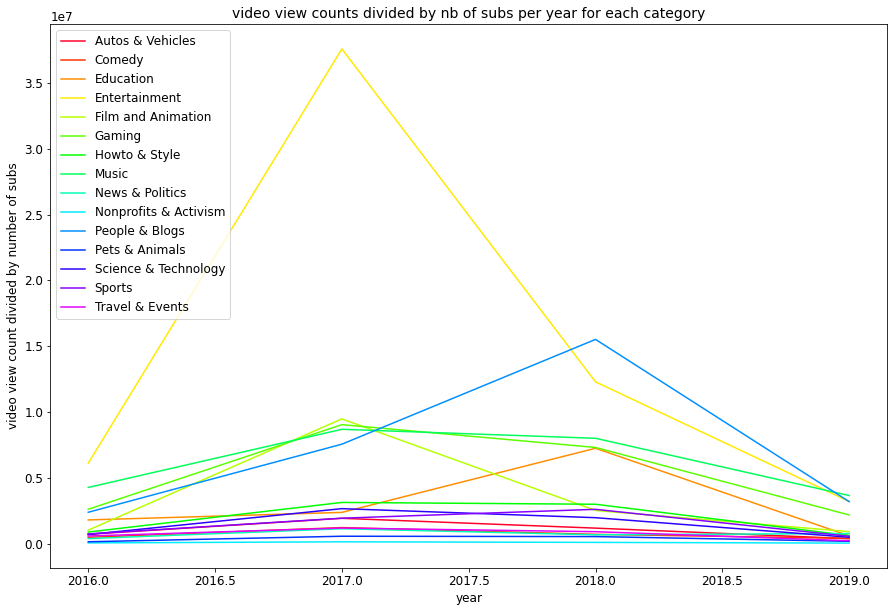

In [96]:
NUM_COLORS = 15
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(views_over_subs_per_year.shape[0]):
    plt.plot(
        views_over_subs_per_year.loc[
            i,
        ][2:],
        label=views_over_subs_per_year.loc[i,][
            0:1
        ][0],
    )
    
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count divided by number of subs")
plt.title("video view counts divided by nb of subs per year for each category")
plt.show()

### Section 2: Number of Likes and Dislikes

In [37]:
video_like_count_by_year = video_count_by_year.like_count.unstack().reset_index()
video_like_count_by_year.columns.name = None
video_like_count_by_year = video_like_count_by_year.sort_values(
    by=2019, ascending=False, ignore_index=True
)


In [38]:
video_dislike_count_by_year = video_count_by_year.dislike_count.unstack().reset_index()
video_dislike_count_by_year.columns.name = None
video_dislike_count_by_year = video_dislike_count_by_year.sort_values(
    by=2019, ascending=False, ignore_index=True
)

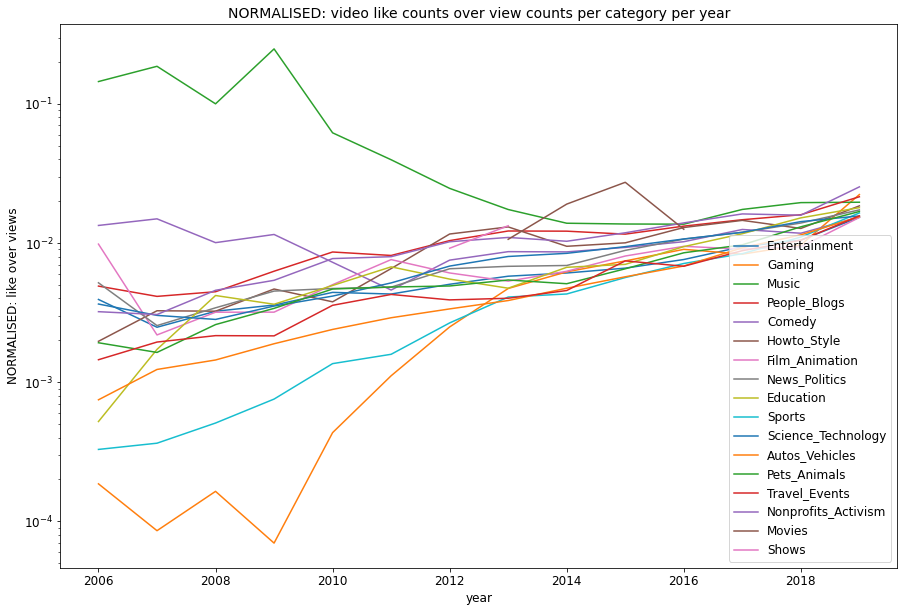

In [83]:
## 3. like count versus view count - normalise wrt. total like counts over view counts for each category for each year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (video_view_count_by_year.loc[i][2:]),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.semilogy()
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("NORMALISED: like over views")
plt.title("NORMALISED: video like counts over view counts per category per year")
plt.show()


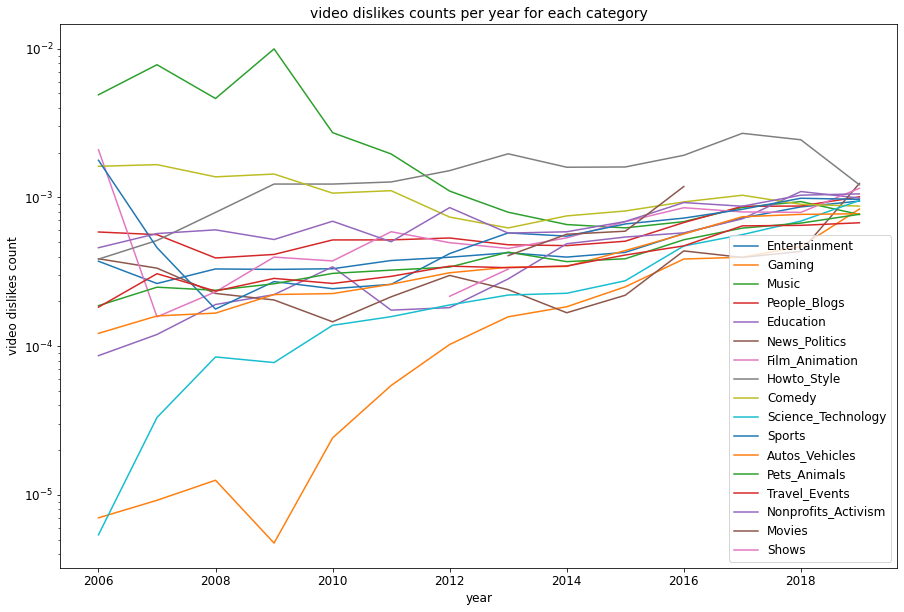

In [90]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_dislike_count_by_year.shape[0]):
    plt.plot(
        video_dislike_count_by_year.loc[
            i,
        ][2:]
        / (video_view_count_by_year.loc[i][2:]),
        label=video_dislike_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.semilogy()  
plt.legend(loc="lower right")
plt.xlabel("year")
plt.ylabel("video dislikes count")
plt.title("video dislikes counts per year for each category")
plt.show()


TO DISCUSS: SHOULD WE STILL INCLUDE THESE TWO GRAPHS?

# Part 2: Further Analysis

In this section, we will focus on three specific categories and determine what are the factors that could lead to more subscriptions.

## Question 1: How does the video upload frequency, time of the week, and video length affect the subscription rate of the channels?
TO-DO: ADD NOTES


## Question 2: What type of titles attract more attention?
TO-DO: ADD NOTES


In [ ]:
POSITIVE_URL = 'https://ptrckprry.com/course/ssd/data/positive-words.txt'
NEGATIVE_URL = 'https://ptrckprry.com/course/ssd/data/negative-words.txt'

def get_words(URL):
    r = requests.get(URL)
    data = r.text
    words = []
    for line in data.split('\n'):
        if ';' not in line and len(line) != 0:
            words.append(line)
    return words

positive_words = get_words(POSITIVE_URL)
negative_words = get_words(NEGATIVE_URL)

# compare the words in the headline with the words in the list of pos and neg words otherwise it is too expansive 
def get_columns_pos_neg(list_words, headline_nb):
    new_column = []
    for headline in combinations_headline_df['headline' + str(headline_nb)]:
        # get all the words in the headline without ponctuation to be ready to be compared with the neg and pos words  
        headline_words = re.sub(r'[^\w\s]', '', headline).split(' ')
        if any(word in list_words for word in headline_words):
            new_column.append(1)
        else :
            new_column.append(0)      
    return new_column

## Question 3: Dig deeper into how does the upload frequency affect subscription number
TO-DO: ADD NOTES


## Question 4:  Can we predict the channel's success based on channel information, including average video length, upload frequency, usual time of uploads, categories of videos uploaded, positive/negative sentiments of the title, usual way of addressing the viewers, the number of words in the title, and the number of tags used.
TO-DO: ADD NOTES
